<a href="https://colab.research.google.com/github/nrobin56/ConceptMap_NLP/blob/main/Concept_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install numpy pandas nltk yake keybert sentence-transformers spacy networkx matplotlib

In [12]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import nltk
import yake
from keybert import KeyBERT
import spacy

# Load spaCy model for preprocessing
nlp = spacy.load("en_core_web_sm")

# Sample textbook paragraph from "Introduction to Machine Learning"
text = """
Machine learning is a method of data analysis that automates analytical model building.
Using algorithms that iteratively learn from data, machine learning allows computers to
find hidden insights without being explicitly programmed where to look.
"""

# Preprocess text
def preprocess(text):
    doc = nlp(text.lower())  # Lowercase and tokenize
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

cleaned_text = preprocess(text)

# Keyword Extraction with YAKE
yake_extractor = yake.KeywordExtractor(n=2, top=5)
yake_keywords = yake_extractor.extract_keywords(cleaned_text)

# Keyword Extraction with KeyBERT
kw_model = KeyBERT()
bert_keywords = kw_model.extract_keywords(cleaned_text, keyphrase_ngram_range=(1,2), stop_words='english', top_n=5)

# Display results
print("YAKE Keywords:", [kw[0] for kw in yake_keywords])
print("KeyBERT Keywords:", [kw[0] for kw in bert_keywords])


YAKE Keywords: ['machine learning', 'analysis automate', 'automate analytical', 'analytical model', 'model building']
KeyBERT Keywords: ['analysis automate', 'automate analytical', 'datum analysis', 'method datum', 'learn datum']


In [14]:
!pip install networkx matplotlib sentence-transformers

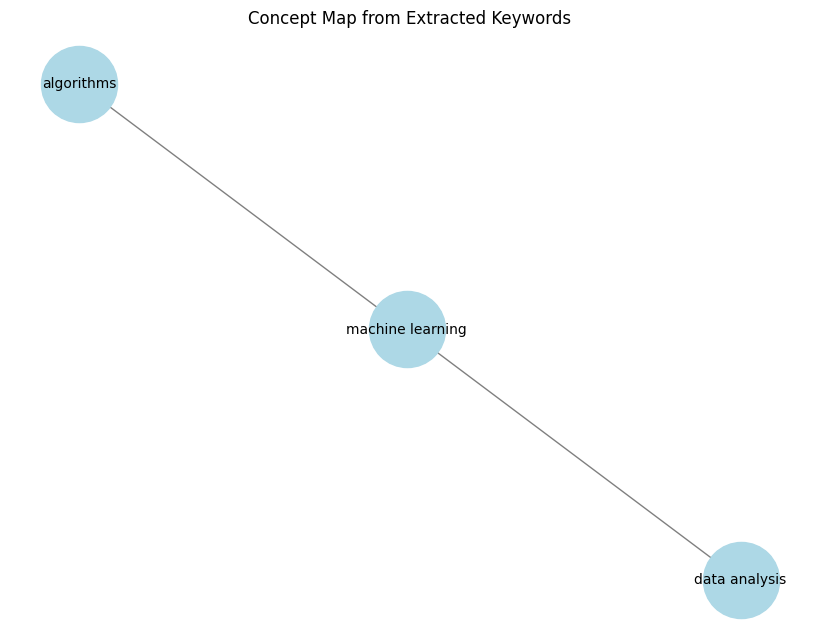

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# Load pre-trained sentence embedding model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Sample concepts extracted from the textbook
concepts = ["machine learning", "data analysis", "analytical model", "algorithms", "computers", "hidden insights"]

# Compute similarity scores between concepts
similarity_matrix = {}
for i, concept1 in enumerate(concepts):
    for j, concept2 in enumerate(concepts):
        if i < j:  # Avoid duplicate comparisons
            embedding1 = sbert_model.encode(concept1, convert_to_tensor=True)
            embedding2 = sbert_model.encode(concept2, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(embedding1, embedding2).item()
            if similarity > 0.5:  # Threshold for considering a relationship
                similarity_matrix[(concept1, concept2)] = similarity

# Create a graph using NetworkX
G = nx.Graph()
for (c1, c2), sim in similarity_matrix.items():
    G.add_edge(c1, c2, weight=sim)

# Draw the concept map
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)
plt.title("Concept Map from Extracted Keywords")
plt.show()


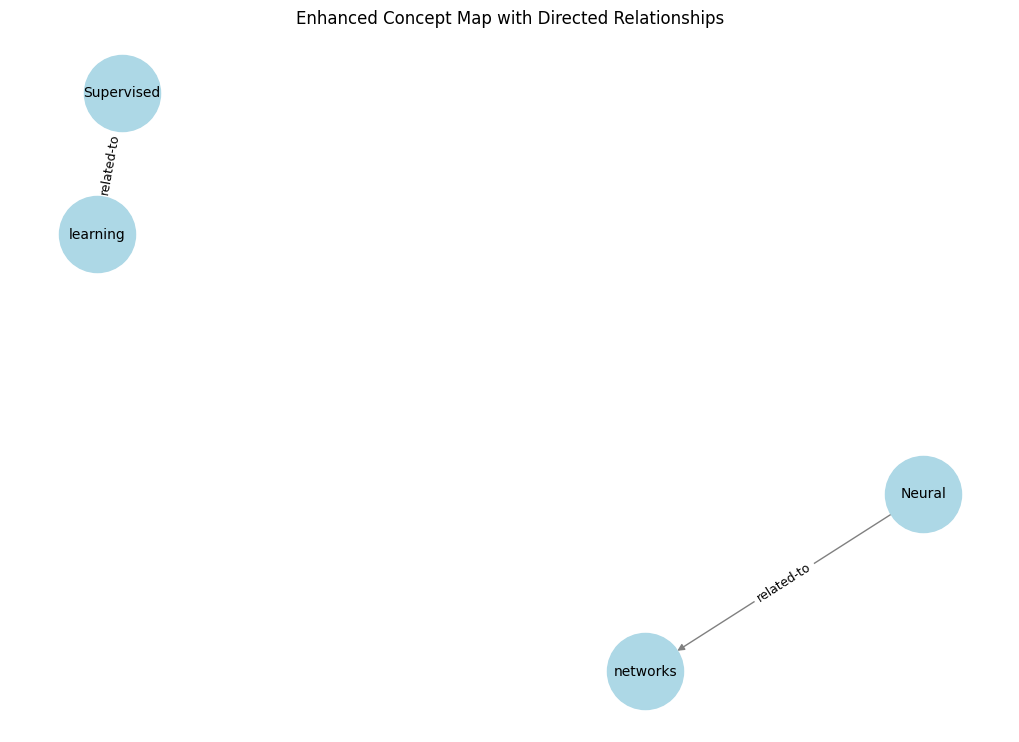

In [16]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# Load pre-trained models
nlp = spacy.load("en_core_web_sm")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Sample textbook excerpt
text = """
Machine learning is a field of artificial intelligence that allows computers to learn from data.
Supervised learning is a type of machine learning where models are trained on labeled data.
Neural networks are used in deep learning, a subset of machine learning, for complex pattern recognition.
"""

# Extract concepts using dependency parsing
def extract_concepts(text):
    doc = nlp(text)
    concepts = set()
    relations = []

    for token in doc:
        if token.pos_ in {"NOUN", "PROPN"}:  # Extract key nouns as concepts
            concepts.add(token.text)
            for child in token.children:
                if child.dep_ in {"amod", "compound", "nsubj", "dobj"}:
                    relations.append((child.text, token.text, "related-to"))  # Generic relation

    return list(concepts), relations

concepts, relations = extract_concepts(text)

# Compute semantic similarity for stronger relations
semantic_relations = []
for c1, c2, rel in relations:
    embedding1 = sbert_model.encode(c1, convert_to_tensor=True)
    embedding2 = sbert_model.encode(c2, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embedding1, embedding2).item()
    if similarity > 0.5:  # Only keep meaningful relationships
        semantic_relations.append((c1, c2, rel))

# Create a directed graph
G = nx.DiGraph()
for c1, c2, rel in semantic_relations:
    G.add_edge(c1, c2, label=rel)

# Draw the directed concept map
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10, edge_color="gray", arrows=True)
edge_labels = {(c1, c2): rel for c1, c2, rel in semantic_relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.title("Enhanced Concept Map with Directed Relationships")
plt.show()
